In [2]:
import pandas as pd
import numpy as np

In [1]:
A = [1, 2, 3, 4]
B = A[1:]
print(B)

[2, 3, 4]


In [25]:
def calculate_abs(x, y, z):
    return np.sqrt((x**2+y**2+z**2))
def calculate_decay_position(px, py, pz, m, ctau, prod_x, prod_y, prod_z):
    p = calculate_abs(px, py, pz)
    k = p/m
    # kx = px/m
    # ky = py/m
    # kz = pz/m
    # vx = np.sqrt(1/(1+(np.square(kx))))*kx
    # vy = np.sqrt(1/(1+(np.square(ky))))*ky
    # vz = np.sqrt(1/(1+(np.square(kz))))*kz
    v = np.sqrt(k**2/(1+(np.square(k)))) # V's Unit is C
    # gamma = k/v
    gamma = 1/np.sqrt(1-v**2)
    r = v * ctau * gamma # The ctau's Unit is mm/C
    x = r * (px/p) + prod_x
    y = r * (py/p) + prod_y
    z = r * (pz/p) + prod_z
    # print(kx, ky, kz)
    # print(gamma)
    # print(gamma2)
    # return gamma, gamma2
    return pd.DataFrame({'r': r, 'x': x, 'y': y, 'z': z})

def calculate_gamma(px, py, pz, energy):
    p_vec = np.array([px, py, pz])
    p = calculate_abs(px, py, pz)
    mass = np.sqrt(energy**2 - p**2)
    gamma = energy / mass
    gamma2 = 1/np.sqrt(1 - (p/energy)**2)
    return gamma, gamma2

In [23]:
file = '/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Program/PRA/Github/position_read_analyse_1.3/ALL_IN_ONE/Momentum_Analyse/test.csv'
df = pd.read_csv(file)
p = np.array([df['e'], df['p_x'], df['p_y'], df['p_z']])
p_3 = p[1:]
ltime = np.array(df['tau'])
m = df['m']
gamma = p[1]/m
beta_3 = np.array(p_3/(p[1]))
prod_3 = np.array([df['xProd'], df['yProd'], df['zProd']])
# print(beta_3)
# print('--------------')
# print(ltime)
# print('------------')
decay_pos = np.array([df['decay_pos_x'], df['decay_pos_y'], df['decay_pos_z']])
# decay_pos_calcu = beta_3 * ltime + prod_3
df_decay_pos_calcu = calculate_decay_position(p_3[0], p_3[1], p_3[2], m, ltime, prod_3[0], prod_3[1], prod_3[2])
decay_pos_calcu = np.round(np.array([df_decay_pos_calcu['x'], df_decay_pos_calcu['y'], df_decay_pos_calcu['z']]),1)
print(decay_pos)
print('-------------------')
print(decay_pos_calcu)
print('------------------')
print(decay_pos-decay_pos_calcu)

[[34837.1  34837.1  29250.6  29250.6  29452.4  29452.4  31922.9  31922.9 ]
 [ 2106.49  2106.49 -5241.81 -5241.81 -4963.59 -4963.59 -5446.34 -5446.34]
 [13744.   13744.   11781.7  11781.7   6292.72  6292.72  7212.72  7212.72]]
-------------------
[[34837.1 34837.1 29250.5 29250.5 29452.5 29452.5 31922.9 31922.9]
 [ 2106.5  2106.5 -5241.8 -5241.8 -4963.6 -4963.6 -5446.3 -5446.3]
 [13744.  13744.  11781.7 11781.7  6292.7  6292.7  7212.7  7212.7]]
------------------
[[ 0.    0.    0.1   0.1  -0.1  -0.1   0.    0.  ]
 [-0.01 -0.01 -0.01 -0.01  0.01  0.01 -0.04 -0.04]
 [ 0.    0.    0.    0.    0.02  0.02  0.02  0.02]]


-------------------
sim decay_pos_z ave0.9474718715152637
-------------------
pythia8 decay_pos_z ave-3.037376267871444
-------------------
1.226015581548374
-------------------
1.2077977091368293
清理后数据量: Group sim = 4228, Group pythia8 = 34304
Bootstrap均值差异: 4.0480 ± 5.5589
95% 置信区间: [-6.9085, 14.9380]
统计显著性: 否 (置信区间包含0)


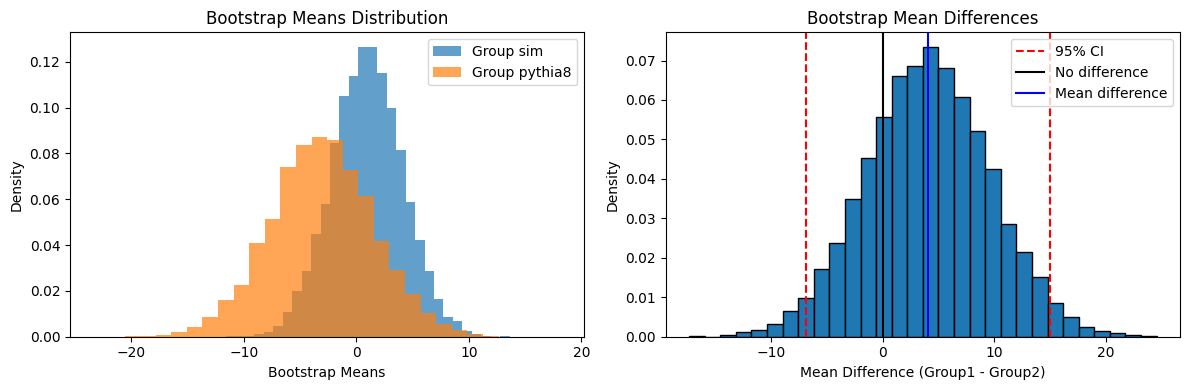

In [49]:
import decay_sim as ds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
labels=['Group sim', 'Group pythia8']
decay_sim = pd.read_csv('/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Program/PRA/Github/position_read_analyse_1.3/test/test_decay.csv')
decay_pythia8 = pd.read_csv('/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Program/PRA/Github/position_read_analyse_1.3/test/test/2025-11-30_2HDM_B_test/LLP_data/pythia8_1.csv')

def bootstrap_comparison(data1, data2, n_bootstrap=1000):
    """
    使用bootstrap方法对比分布，包含NaN值处理
    """
    # 检查并清理数据
    data1_clean = np.array(data1)[~np.isnan(data1)]
    data2_clean = np.array(data2)[~np.isnan(data2)]
    
    print(f"清理后数据量: {labels[0]} = {len(data1_clean)}, {labels[1]} = {len(data2_clean)}")
    
    if len(data1_clean) == 0 or len(data2_clean) == 0:
        print("错误: 清理后数据为空")
        return None, None
    
    # 重采样到相同样本量
    min_size = min(len(data1_clean), len(data2_clean))
    
    bootstrap_diffs = []
    bootstrap_means1 = []
    bootstrap_means2 = []
    
    for i in range(n_bootstrap):
        try:
            # 从每个组中重采样
            sample1 = np.random.choice(data1_clean, size=min_size, replace=True)
            sample2 = np.random.choice(data2_clean, size=min_size, replace=True)
            
            mean1 = np.mean(sample1)
            mean2 = np.mean(sample2)
            
            # 检查计算结果是否为NaN
            if not np.isnan(mean1) and not np.isnan(mean2):
                bootstrap_diffs.append(mean1 - mean2)
                bootstrap_means1.append(mean1)
                bootstrap_means2.append(mean2)
                
        except Exception as e:
            print(f"Bootstrap迭代 {i} 出错: {e}")
            continue
    
    if len(bootstrap_diffs) == 0:
        print("错误: 所有bootstrap样本都包含NaN值")
        return None, None
    
    # 计算bootstrap置信区间
    ci_lower = np.percentile(bootstrap_diffs, 2.5)
    ci_upper = np.percentile(bootstrap_diffs, 97.5)
    
    mean_diff = np.mean(bootstrap_diffs)
    std_diff = np.std(bootstrap_diffs)
    
    print(f"Bootstrap均值差异: {mean_diff:.4f} ± {std_diff:.4f}")
    print(f"95% 置信区间: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    # 检查差异是否显著
    if ci_lower > 0 or ci_upper < 0:
        print("统计显著性: 是 (置信区间不包含0)")
    else:
        print("统计显著性: 否 (置信区间包含0)")
    
    # 绘制bootstrap分布
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(bootstrap_means1, alpha=0.7, label=labels[0], bins=30, density=True)
    plt.hist(bootstrap_means2, alpha=0.7, label=labels[1], bins=30, density=True)
    plt.xlabel('Bootstrap Means')
    plt.ylabel('Density')
    plt.legend()
    plt.title('Bootstrap Means Distribution')
    
    plt.subplot(1, 2, 2)
    plt.hist(bootstrap_diffs, bins=30, edgecolor='black', density=True)
    plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI')
    plt.axvline(ci_upper, color='red', linestyle='--')
    plt.axvline(0, color='black', linestyle='-', label='No difference')
    plt.axvline(mean_diff, color='blue', linestyle='-', label='Mean difference')
    plt.xlabel('Mean Difference (Group1 - Group2)')
    plt.ylabel('Density')
    plt.legend()
    plt.title('Bootstrap Mean Differences')
    
    plt.tight_layout()
    plt.show()
    
    return bootstrap_diffs, (ci_lower, ci_upper)
mean_sim_z = np.mean(decay_sim['decay_pos_z'])
mean_pythia8_z = np.mean(decay_pythia8['decay_pos_z'])
print('-------------------')
print('sim decay_pos_z ave'+f'{mean_sim_z}')
print('-------------------')
print('pythia8 decay_pos_z ave'+f'{mean_pythia8_z}')

# gamma1, gamma2 = calculate_gamma(decay_pythia8['p_x'], decay_pythia8['p_y'], decay_pythia8['p_z'], decay_pythia8['e'])
# tau_lab = decay_pythia8['tau'] * gamma1
# print(gamma1[:5])
print('-------------------')
print(np.mean(decay_sim['tau']))
print('-------------------')
print(np.mean(decay_pythia8['tau']))
# X_diff = bootstrap_comparison(decay_sim['decay_pos_x'], decay_pythia8['decay_pos_x'], n_bootstrap=10000)
# Y_diff = bootstrap_comparison(decay_sim['decay_pos_y'], decay_pythia8['decay_pos_y'], n_bootstrap=10000)
Z_diff = bootstrap_comparison(decay_sim['decay_pos_z'], decay_pythia8['decay_pos_z'], n_bootstrap=10000)
# df = pd.DataFrame(decay_pos, columns=['decay_pos_x', 'decay_pos_y', 'decay_pos_z'])
# df.to_csv('/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Program/PRA/Github/position_read_analyse_1.3/test/test_decay.csv')


In [ ]:
decay_521 = pd.read_csv('/media/ubuntu/6156e08b-fdb1-4cde-964e-431f74a6078e/Program/PRA/Github/position_read_analyse_1.3/ALL_IN_ONE/Momentum_Analyse/B_521.csv')

prod_z_diff = bootstrap_comparison(decay_521['decay_pos_z_521'], decay_pythia8['zProd'], n_bootstrap=10000)

KeyError: 'decay_pos_z'

[[0.00000000e+00 3.26561321e-14 6.46617491e-14 ... 1.52320010e-15
  1.50954148e-15 1.49600383e-15]
 [0.00000000e+00 4.89841982e-14 9.69926236e-14 ... 2.28480015e-15
  2.26431222e-15 2.24400575e-15]
 [0.00000000e+00 6.53122642e-14 1.29323498e-13 ... 3.04640020e-15
  3.01908296e-15 2.99200766e-15]]


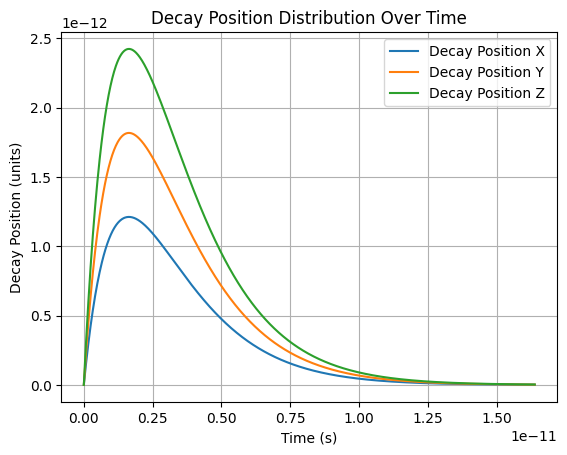

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def decay_distribution(ltime, momentum):
    t = np.linspace(0, 10*ltime, 1000)
    posibility = np.exp(- (t/ltime))
    decay_pos_x = posibility * t * momentum[1]
    decay_pos_y = posibility * t * momentum[2]
    decay_pos_z = posibility * t * momentum[3]
    decay_pos = np.array([decay_pos_x, decay_pos_y, decay_pos_z])
    # decay_r = np.abs(decay_pos)
    gamma = momentum[0] / np.sqrt(momentum[0]**2 - np.dot(momentum[1:], momentum[1:]))
    decay_pos = decay_pos * gamma  # time dilation
    return decay_pos

ltime = 1.638e-12  # seconds
momentum = np.array([50, 2, 3, 4])
print(decay_distribution(ltime, momentum))

plt.figure()
r = decay_distribution(ltime, momentum)
t = np.linspace(0, 10*ltime, 1000)
plt.plot(t, r[0], label='Decay Position X')
plt.plot(t, r[1], label='Decay Position Y')
plt.plot(t, r[2], label='Decay Position Z')
plt.xlabel('Time (s)')
plt.ylabel('Decay Position (units)')
plt.title('Decay Position Distribution Over Time')
plt.legend()
plt.grid()
plt.show()

In [2]:
test = [0, 1, 2, 3]
print(test[1:])

[1, 2, 3]
